In [210]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import cross_val_score

In [4]:
#Establish Column Names
column_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
                'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', '50K']

#Establish Data
adult_data = pd.read_csv('adult.data', names = column_names)

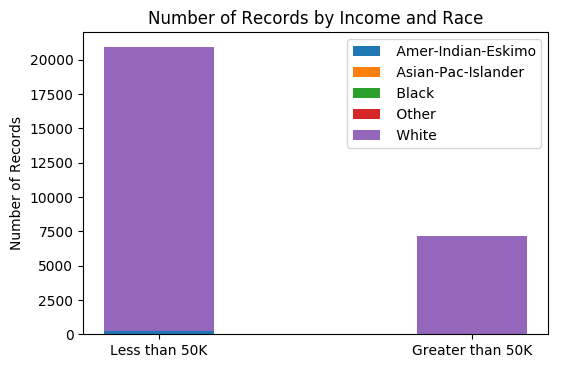

In [216]:

agg_adult_data = adult_data.groupby(['50K','race'])['50K'].count().reset_index(name='count')
N = 2
race_1 = agg_adult_data[agg_adult_data['race']==' Amer-Indian-Eskimo']['count'].tolist()
race_2 = agg_adult_data[agg_adult_data['race']==' Asian-Pac-Islander']['count'].tolist()
race_3 = agg_adult_data[agg_adult_data['race']==' Black']['count'].tolist()
race_4 = agg_adult_data[agg_adult_data['race']==' Other']['count'].tolist()
race_5 = agg_adult_data[agg_adult_data['race']==' White']['count'].tolist()

fig, ax1 = plt.subplots()
fig.dpi =100

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = ax1.bar(ind, race_1, width)
p2 = ax1.bar(ind, race_2, width, bottom=race_1)
p3 = ax1.bar(ind, race_3, width, bottom=race_2)
p4 = ax1.bar(ind, race_4, width, bottom=race_3)
p5 = ax1.bar(ind, race_5, width, bottom=race_4)

plt.ylabel('Number of Records')
plt.title('Number of Records by Income and Race')
plt.xticks(ind, ('Less than 50K', 'Greater than 50K'))

#plt.yticks(np.arange(0, 20000, 100))
plt.legend((p1[0], p2[0],p3[0],p4[0],p5[0] ), np.unique(agg_adult_data['race']))

plt.show()

The purpose of the above visualization was to understand how balanced the dataset was while looking into a categorical variable of interest. The categorical variable, race, was encoded using the color channel with the number of records using length and Income using the horizontal spatial position. Per the slides and book (VAD page 102), these are the top ways to encode a magnitude variable and categorical variables. Through the visualization it is evident this dataset is nearly completely reflective of the white race, but more importantly the predictive attribute is unbalanced. This is important considering the classification model. 

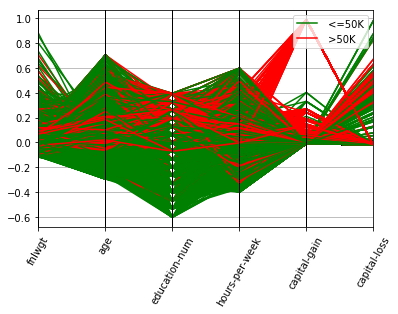

In [231]:
#Keep only contiuous variables and see relationship
continuous = adult_data[['fnlwgt','age','education-num', 'hours-per-week','capital-gain','capital-loss']]
continuous_norm = (continuous - continuous.mean()) / (continuous.max() - continuous.min())

continuous_norm = pd.concat([continuous_norm, adult_data['50K']], axis=1)

pd.plotting.parallel_coordinates(continuous_norm, '50K', color=('g', 'r'))
plt.xticks(rotation=60)
plt.show()

The parallel coordingate plot was chosen because it encodes multiple continuous/quantitative variables and helps visualize their relationship with the categorical variables "50K". The latter is encoded using the hue channel. Overall, it aids in the primary task which is to find trends, outliers, extremes, and correlations. (VAD Chapter 7 pg 166). We can clearly see that a majority of the people with income over 50K have high education number as well as some captial gains. 

In [56]:
#Create m-1 Dummy Variables for each categorical variable with m values

def dummies(df, col):
    new_df = pd.get_dummies(df[col])
    new_df = new_df.iloc[:,1:len(new_df.columns)]
    
    return new_df

workclass = dummies(adult_data, 'workclass') # ? is default value ex. when everything =0
education = dummies(adult_data, 'education') #10th is default value ex. when everything =0
marital = dummies(adult_data, 'marital-status')# Divorced is default value ex. when everything =0 
occup = dummies(adult_data, 'occupation') # ? is default value ex. when everything =0 
relat = dummies(adult_data, 'relationship') #Husband is default value ex. when everything =0
race = dummies(adult_data, 'race') #Amer-Indian-Eskimo is default value ex. when everything =0
sex = dummies(adult_data, 'sex')# Female is default value ex. when everything =0
country = dummies(adult_data, 'native-country') # ? is default value ex. when everything =0 
income = dummies(adult_data, '50K') # <50K is default value ex. when everything =0 


#Contiuous variables 

X_data = adult_data[['age','fnlwgt','education-num', 'capital-gain','capital-loss', 'hours-per-week']]

#Merge to New Dataset 

frames = [adult_data2, workclass, education, marital, occup, relat, race, sex, country]
X_data = pd.concat(frames, axis=1)
Y_data = income

In [84]:
#Split data into training and testing data

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.20)  
 
#Normalize inputs according to training data mean and std    
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 
Y_train = np.array(Y_train).ravel()
Y_test = np.array(Y_test).ravel()

In order to properly account for categorical variables in the euclidean space, I transformed them into $m-1$ dummy variables where $m$ is the number of values or categories each variable has with values being binary. The purpose of selecting m-1 dummy variables is to remove redundancy. Next, I split the data into our training and test where both can normalized according to the train data mean and std. 

In [87]:
#Initialize K Values
k = range(1,11) # K values
dist = [1,2] #When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. 

# Calculating error for K values between 1 and 10
accuracy = []
for i in dist:
    for j in k:  
        knn = KNeighborsClassifier(n_neighbors = j, p = i)
        scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='precision') #Return 10 test precision        
        accuracy.append([i, j, scores]) # Append the precision scores from Cross Validation 
        
        

In [99]:
precision_scores = pd.DataFrame(accuracy, columns = ['Distance_Metric', 'K', 'Precision_Scores'])

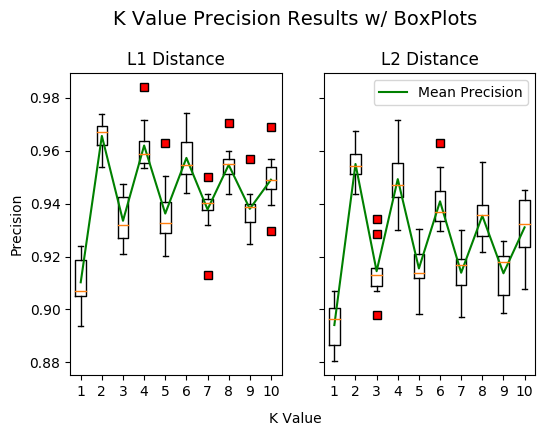

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.dpi =100


x = precision_scores['Precision_Scores'][0:10]
ax1.boxplot(x, flierprops= dict(markerfacecolor='r', marker='s'))
ax1.set_title('L1 Distance')
ax1.set_xticks(range(1,11))

ax1.set_ylabel('Precision')   
ax1.plot(range(1,11), np.mean(precision_scores['Precision_Scores'].tolist(), axis =1)[0:10], c ='g')

x = precision_scores['Precision_Scores'][10:20]
ax2.boxplot(x,flierprops= dict(markerfacecolor='r', marker='s'))
ax2.set_title('L2 Distance')
ax2.set_xticks(range(1,11))

ax2.plot(range(1,11), np.mean(precision_scores['Precision_Scores'].tolist(), axis =1)[10:20], c ='g',label = 'Mean Precision')
fig.text(0.5, 0.005, 'K Value', ha='center')
fig.text(0.5, 1,'K Value Precision Results w/ BoxPlots',ha='center', fontsize=14)
plt.legend()
plt.show()


The task relating to the image above is to draw a clear conclusion pertaining to the evaluation metric ( precision) produced in the 10 fold cross validation. In order to take as much information as we can, we implement the boxplot which encodes multiple derived quantitative attributes using the vertical spatial position. Included in the boxplot are outliers so we encode these with the channels hue and shape. By doing so, users can clearly see that these outliers may skew the mean. The mean is encoded using a line plot with the color channel being green so that it pops out. I believe the line plot emphasizes the length among each K Value, which according to psychophysical power law of Stevens (VAD page 104) entails it is accurate , such that humans perceive the data effectively. The line also allows the user to see trends in terms of how the line moves over the horizontal spatial position (K values).  

In [187]:
# Train data with optimal k and distance measurement
classifier = KNeighborsClassifier(n_neighbors=2, p =1)  
classifier.fit(X_train, Y_train) 
Y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix  
acc = (confusion_matrix(Y_test, Y_pred)[0,0]+confusion_matrix(Y_test, Y_pred)[1,1])/confusion_matrix(Y_test, Y_pred).sum()

print('Confusion Matrix:\n', confusion_matrix(Y_test, Y_pred)) 
print('\nAccuracy: ',acc )
print(classification_report(Y_test, Y_pred)) 

Confusion Matrix:
 [[4917   27]
 [ 320 1249]]

Accuracy:  0.9467219407339168
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      4944
          1       0.98      0.80      0.88      1569

avg / total       0.95      0.95      0.94      6513

